In [65]:
import sys; sys.path.append('/rds/general/user/cb2714/home/'); from wwa import *

mswx_fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/"

xn, xx, yn, yx = 10, 15, 42, 46

sf = gpd.read_file("../sf_emilia-romagna")

# **Point process analysis of extremely wet days over Emilia-Romagna**

## **Extract SLP daily climatology**

In [66]:
# too much data to read & save in one go - save each year individually
for y in range(1979, 2024):
    
    new_fnm = "tmp/mswx-slp_daily_"+"_".join([str(p) for p in [xn,xx,yn,yx]])+"_"+str(y)+".nc"
    if len(glob.glob(new_fnm)) > 0: continue
    
    fl = sorted([fnm for fnm in glob.glob(mswx_fpath+"slp_*/"+str(y)+"*.nc") if int(fnm[-6:-3]) in range(91,183)]) # select AMJ only
    
    ds = xr.open_mfdataset(fl).sel(lon = slice(xn,xx), lat = slice(yx,yn))
    ds.sortby(ds.lat).to_netcdf(new_fnm)

In [67]:
slp_clim = xr.open_mfdataset("tmp/mswx-slp_daily_"+"_".join([str(p) for p in [xn,xx,yn,yx]])+"_*.nc").groupby("time.dayofyear").mean()
slp_clim.to_netcdf("mswx_slp_daily-clim_"+"_".join([str(p) for p in [xn,xx,yn,yx]])+".nc")

## **Extract SLP patterns on wet days**

In [69]:
wd = xr.open_dataset("mswep_er_vwetdays.nc").precip

wetday_slp = []
for d in wd.time:
    fnm = glob.glob(mswx_fpath+"slp_*/"+str(d.dt.year.values)+str(d.dt.dayofyear.values).rjust(3, "0")+".nc")[0]
    ds = xr.open_dataset(fnm).sel(lon = slice(xn,xx), lat = slice(yx,yn))
    wetday_slp.append(ds)

wetday_slp = xr.concat(wetday_slp, "time")
wetday_slp.to_netcdf("mswx_slp_vwetdays_"+"_".join([str(x) for x in [xn,xx,yn,yx]])+".nc")

## **Classify SLP patterns on wet days**

In [70]:
wetday_slp = xr.open_dataset("mswx_slp_vwetdays_"+"_".join([str(x) for x in [xn,xx,yn,yx]])+".nc").surface_pressure
slp_clim = xr.open_dataset("mswx_slp_daily-clim_"+"_".join([str(x) for x in [xn,xx,yn,yx]])+".nc").surface_pressure

In [71]:
wetday_anom = convert_units_to(wetday_slp.groupby("time.dayofyear") - slp_clim, "hPa")

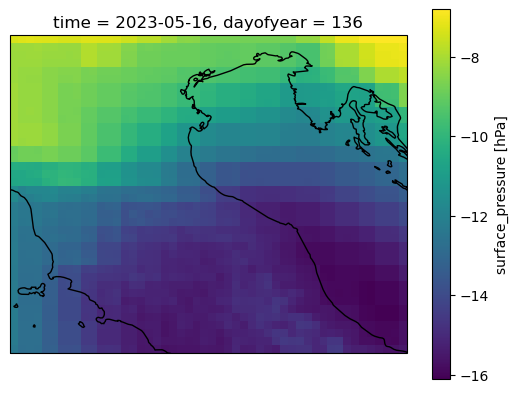

In [72]:
wetday_anom.sel(time = "2023-05-16").plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()})
ax = plt.gca()
ax.coastlines()

In [73]:
# calculate sum of squared distances between all analogues
rmse = [((wetday_anom.isel(time = i) - wetday_anom) ** 2).sum(["lat", "lon"]).rename(time = "event_time").expand_dims(time = [wetday_anom.time[i].values]) for i in range(199)]
rmse = xr.concat(rmse, "time")

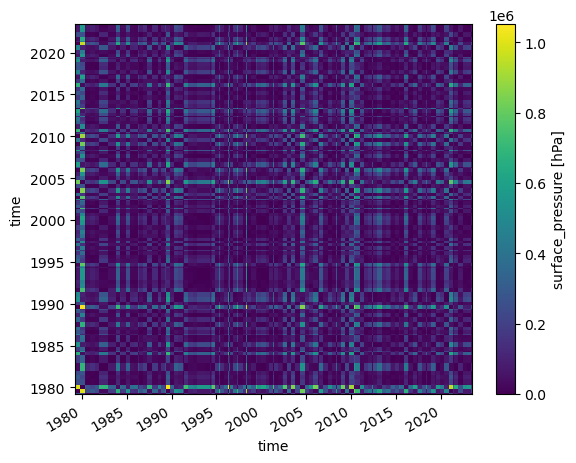

In [74]:
rmse.plot()

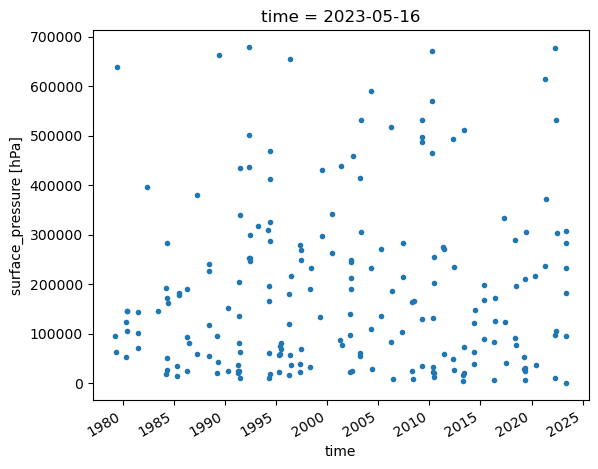

In [75]:
rmse.sel(time = "2023-05-16").plot(ls = "", marker = ".")

In [76]:
ss = rmse.sel(time = "2023-05-16", drop = True).to_dataframe().sort_values("surface_pressure")
ss.iloc[1:10].index

DatetimeIndex(['2013-04-02', '2016-04-24', '2019-05-05', '2008-05-20',
               '2006-05-30', '1994-04-08', '2022-04-22', '1991-06-08',
               '2010-06-20'],
              dtype='datetime64[ns]', name='event_time', freq=None)

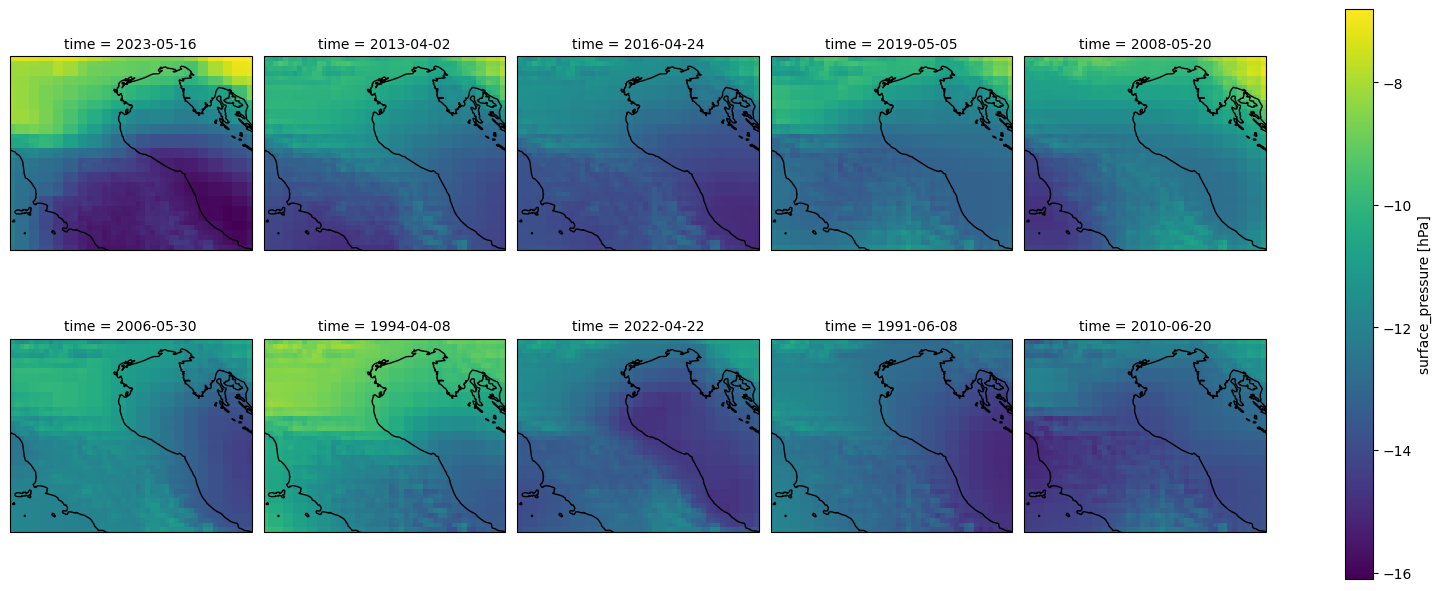

In [77]:
fig = wetday_anom.sel(time = [t for t in ss.iloc[:10].index]).plot(col = "time", col_wrap = 5, subplot_kws = {"projection":cartopy.crs.PlateCarree()})

for ax in fig.axs.flatten():
    ax.coastlines()

---
## **Principal component analysis**

In [56]:
u, s, vh = np.linalg.svd(wetday_anom.stack(xy = ["lat", "lon"]), full_matrices = False)

In [96]:
tss = sum(np.diag(vh.transpose() @ np.diag(s**2) @ vh))

pc = xr.DataArray(name = "anom_pc", data = np.reshape(vh, wetday_anom.shape), dims = wetday_anom.dims, coords = wetday_anom.coords).rename(time = "pc").assign_coords(pc = range(199))
pc = pc

ve = (s**2) / tss * 100

In [120]:
ds = xr.Dataset(data_vars = {"pcs"    : xr.DataArray(data = np.reshape(vh, wetday_anom.shape),
                                                     dims = wetday_anom.dims, coords = wetday_anom.coords).rename(time = "pc").assign_coords(pc = range(199)),
                             "svals"    : (["pc"], s),
                             "var_expl" : (["pc"], (s**2) / tss * 100),
                             "scores"   : (["time", "pc"], u)}).assign_coords(time = wetday_anom.time.values).reset_coords("dayofyear", drop = True)

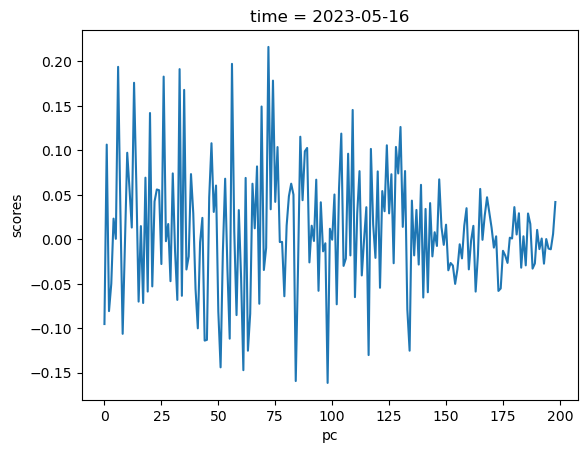

In [122]:
ds.sel(time = "2023-05-16").scores

In [84]:
sc_adj = np.sign(svecs.mean([d for d in svecs.dims if d != "pc"]))
ds["svecs"] = ds["svecs"] * sc_adj

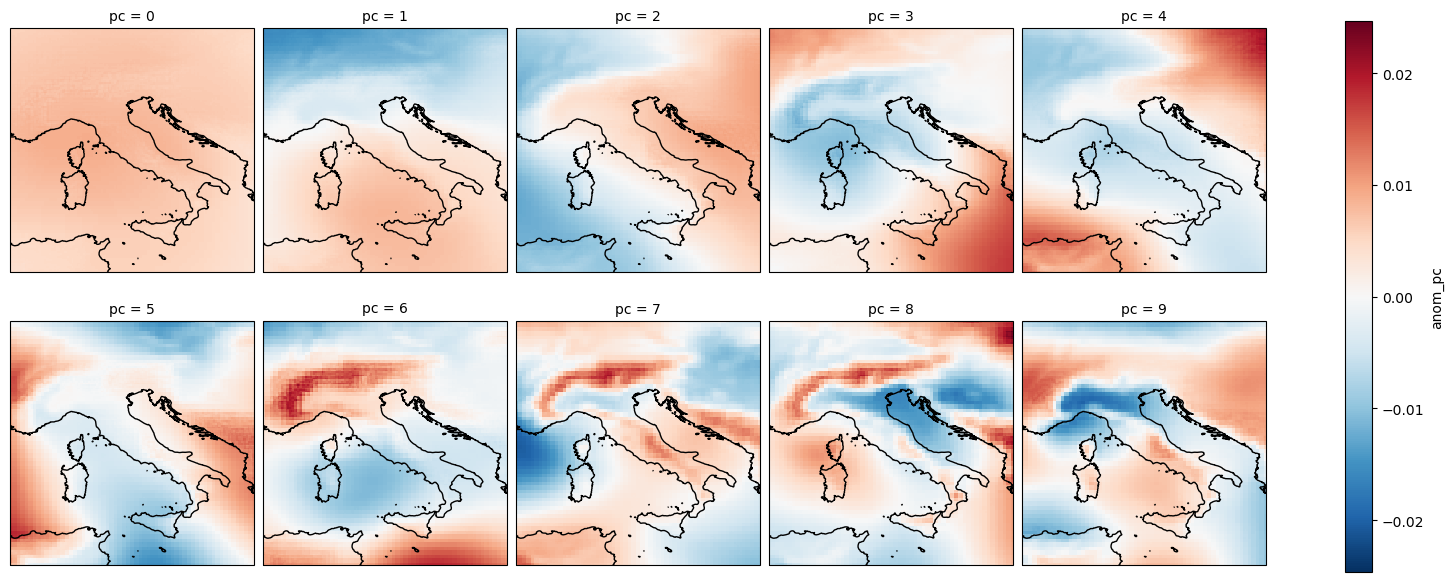

In [94]:
pc.isel(pc = range(10)).plot(col = "pc", col_wrap = 5, subplot_kws = {"projection" : cartopy.crs.PlateCarree()})
for ax in plt.gcf().axes[:-1]:
    ax.coastlines()

## **Cluster by Euclidean distance**
Currently just testing the code - will need to modify this over a smaller domain

In [78]:
from sklearn.cluster import DBSCAN as dbscan
from sklearn.metrics import pairwise_distances as pdist

In [79]:
wetday_slp = xr.open_dataset("mswx_slp_vwetdays_"+"_".join([str(x) for x in [xn,xx,yn,yx]])+".nc").surface_pressure
slp_clim = xr.open_dataset("mswx_slp_daily-clim_"+"_".join([str(x) for x in [xn,xx,yn,yx]])+".nc").surface_pressure

wetday_anom = convert_units_to(wetday_slp.groupby("time.dayofyear") - slp_clim, "hPa")
wetday_anom = wetday_anom.sel(lon = slice(7,15), lat = slice(46,42))

<AxesSubplot: title={'center': 'time = 2023-05-16, dayofyear = 136'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

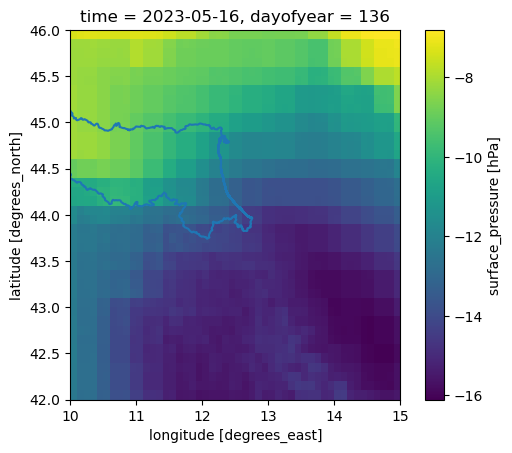

In [80]:
wetday_anom.isel(time = -3).plot()
sf.boundary.plot(ax = plt.gca())

In [94]:
euclidean_dists = pdist(wetday_anom.stack(xy = ["lat", "lon"]), metric = "euclidean") / np.prod(wetday_anom.shape[1:])

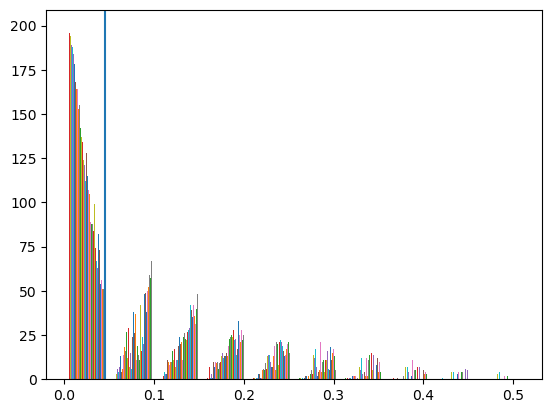

In [95]:
plt.hist(np.triu(euclidean_dists))
plt.axvline(0.045)

In [96]:
euclidean_dists[euclidean_dists <= 0.045].shape

(5491,)

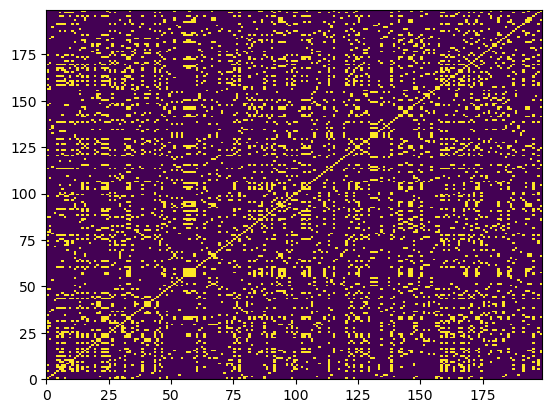

In [97]:
plt.pcolormesh(np.where(euclidean_dists <= 0.045, np.ones_like(euclidean_dists), np.zeros_like(euclidean_dists)))

In [98]:
euclidean_dists

array([[0.        , 0.05999027, 0.26153153, ..., 0.15438162, 0.05727974,
        0.11561266],
       [0.05999027, 0.        , 0.31623316, ..., 0.12567201, 0.10232646,
        0.16860406],
       [0.26153153, 0.31623316, 0.        , ..., 0.39988637, 0.24582067,
        0.16418956],
       ...,
       [0.15438162, 0.12567201, 0.39988637, ..., 0.        , 0.15491474,
        0.24081232],
       [0.05727974, 0.10232646, 0.24582067, ..., 0.15491474, 0.        ,
        0.08830611],
       [0.11561266, 0.16860406, 0.16418956, ..., 0.24081232, 0.08830611,
        0.        ]], dtype=float32)

In [99]:
zz = dbscan(eps=0.1, min_samples=2).fit_predict(euclidean_dists)
wetday_anom = wetday_anom.assign_coords(cluster = ("time", zz))

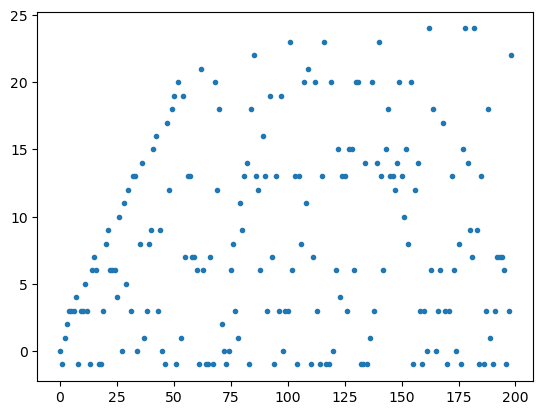

In [100]:
plt.plot(zz, ls = "", marker = ".")

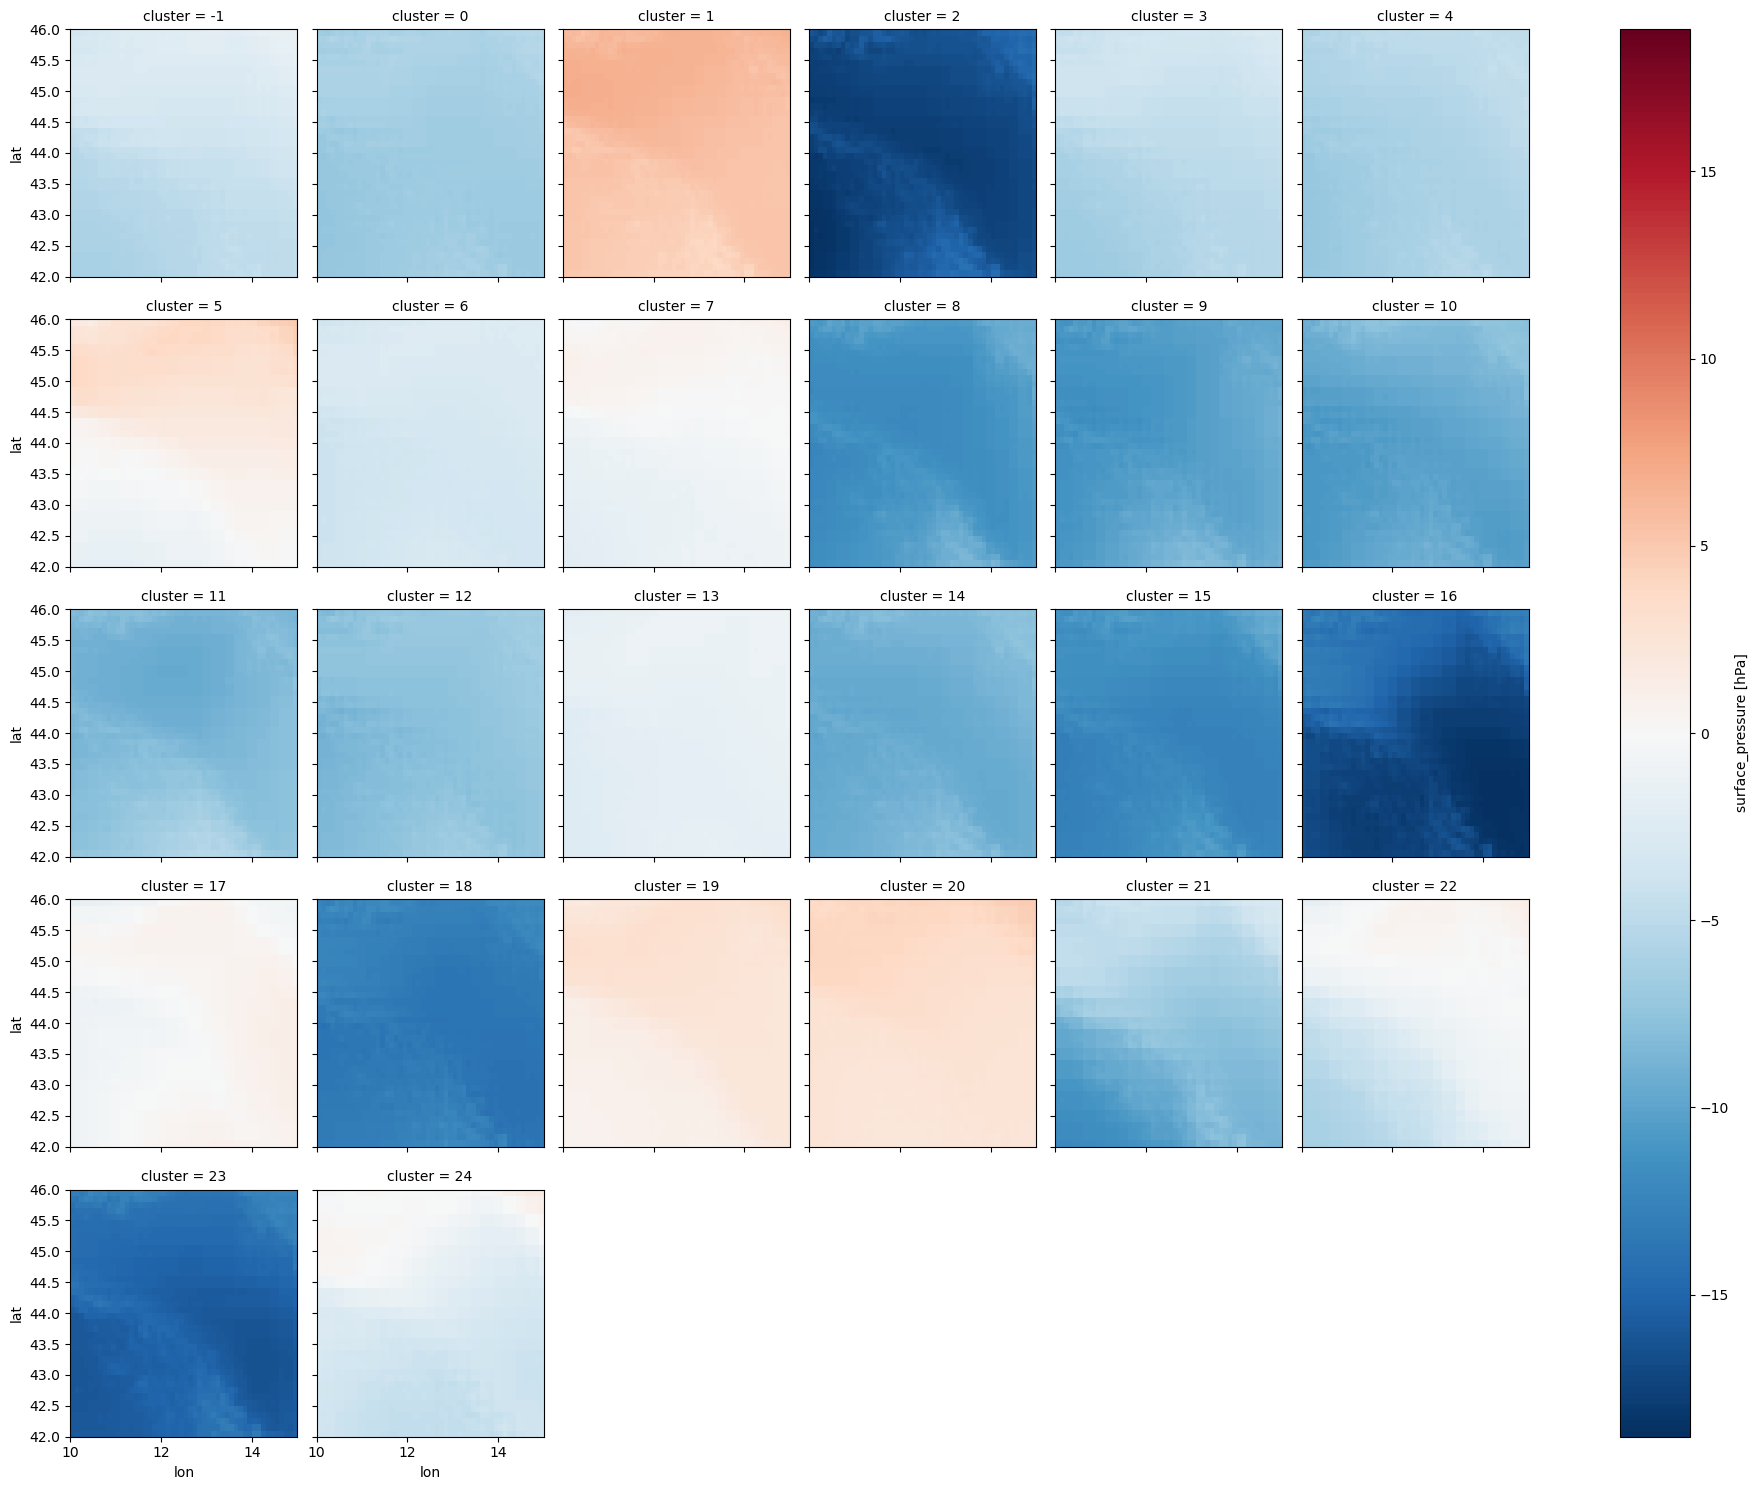

In [101]:
wetday_anom.groupby("cluster").mean("time").plot(col = "cluster", col_wrap = 6)